<a href="https://colab.research.google.com/github/tlchen4/BDRADMiniProject/blob/master/BreastResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast ResNet BDRAD MiniProject



##Import Libraries and Data

Check versions

Mount google drive and load data

In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
from google.colab import drive


print(tf.__version__)
print(matplotlib.__version__)
print(torch.__version__)
print(np.__version__)

1.15.0
3.1.2
1.3.1
1.17.4


In [7]:
drive.mount('/gdrive')
%cd /gdrive

%cd "/gdrive/My Drive/BDRAD Breast MiniProject"
!dir

TrainingData = np.load("ResizedTrainingCompressed.npz", allow_pickle=True)
TestData = np.load("ResizedTestCompressed.npz", allow_pickle=True)

TrainingData['Master_Data'][0][1]
# size = torch.Size([2,2])
# x = torch.empty(size)
# print(x)
# print(size)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
/gdrive/My Drive/BDRAD Breast MiniProject
ResizedTestCompressed.npz  ResizedTrainingCompressed.npz  test	test.png


array([[0.99998474, 0.99998474, 0.99998474, ..., 0.54456652, 0.54711881,
        0.54870736],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.35103934, 0.35648413,
        0.35766997],
       [0.99998474, 0.99998474, 0.99996948, ..., 0.04019114, 0.04222347,
        0.04288102],
       ...,
       [0.99998474, 0.99998474, 0.99998474, ..., 0.26794384, 0.26814883,
        0.26841419],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.33050694, 0.32900271,
        0.32913177],
       [0.99998474, 0.99998474, 0.99998474, ..., 0.4211159 , 0.42277043,
        0.4225252 ]])

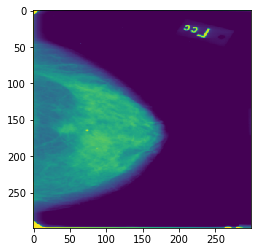

In [0]:
plt.imshow(TrainingData['Master_Data'][0][1])
plt.show()

#check to make sure imported data is what we wanted

##Build and Visualize the  Model

None in output shape refers to a variable dimension. First dimenion in keras models is always the batch size. None allows you to assign a variable batch size later on

In [28]:
CNNModel = tf.keras.models.Sequential()
CNNModel.add(tf.keras.layers.Conv2D(filters=16,kernel_size = (3,3),strides=1,padding="same",activation = 'relu',input_shape=[299,299,1]))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
CNNModel.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),strides=1,padding="same",activation = 'relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
CNNModel.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),strides=1,padding="valid",activation = 'relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
CNNModel.add(tf.keras.layers.Conv2D(filters=32,kernel_size = (3,3),strides=1,padding="valid",activation = 'relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
CNNModel.add(tf.keras.layers.Conv2D(filters=64,kernel_size = (3,3),strides=1,padding="valid",activation = 'relu'))
CNNModel.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
#flatten into vector to feed into dense/fully connected network that ends in a softmax layer for classification
CNNModel.add(tf.keras.layers.Flatten())
CNNModel.add(tf.keras.layers.Dense(64,activation='relu'))
CNNModel.add(tf.keras.layers.Dense(64,activation='relu'))
CNNModel.add(tf.keras.layers.Dense(16,activation='relu'))
CNNModel.add(tf.keras.layers.Dense(2,activation='softmax'))
CNNModel.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 299, 299, 16)      160       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 149, 149, 32)      4640      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 32)       

**Visualize the model**

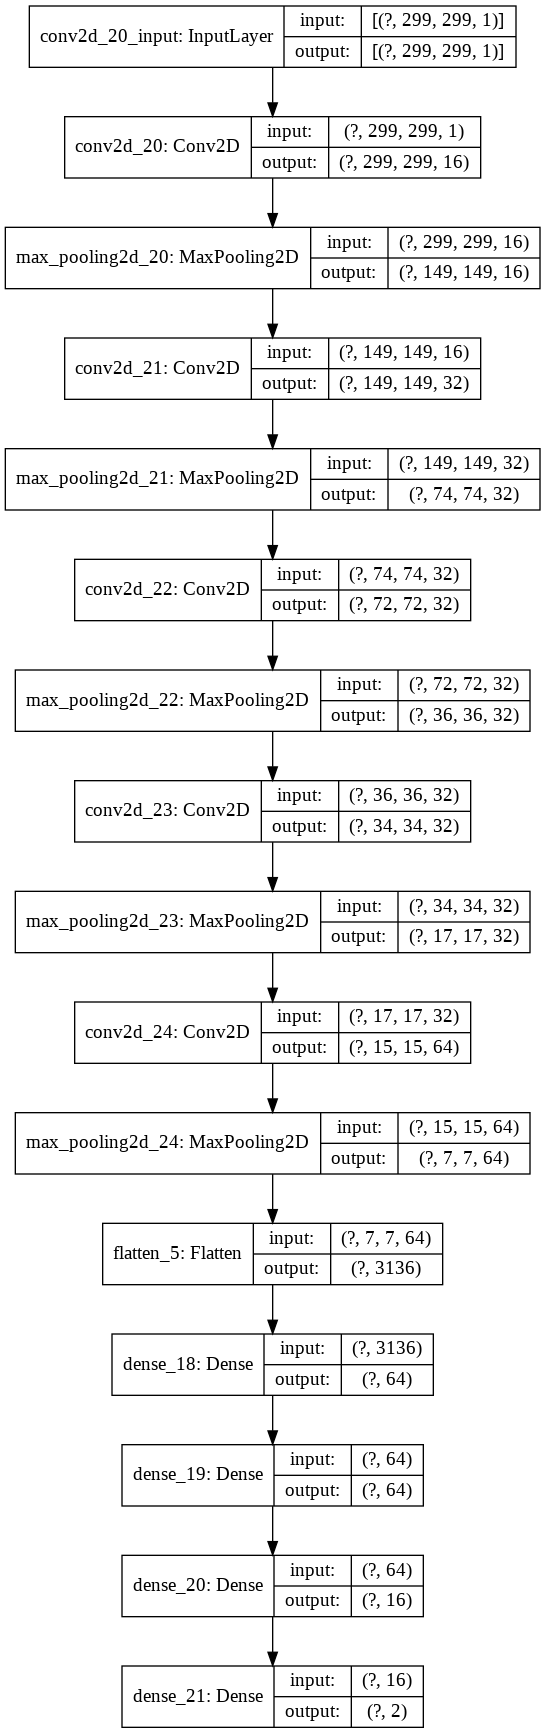

In [29]:
tf.keras.utils.plot_model(CNNModel,'test.png',show_shapes=True)


##Compile Model

In [0]:
CNNModel.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
#recommended settings from keras.io for binary classification



##Train Model

In [0]:
Input_Data=[]
Input_Labels=[]

#Separate out the image data and labels data into separate lists from imported TrainingData
for i in TrainingData['Master_Data']:
  Input_Data.append(i[1])
  Input_Labels.append(i[2])

#Split Data and Label lists into a training and validation sets
Input_Train_Data = Input_Data[0:320]
Input_Validation_Data = Input_Data[320:]

Input_Train_Labels = Input_Labels[0:320]
Input_Validation_Labels = Input_Labels[320:]

#Our CNNModel requires a third dimension to data, so just extend 2D vector to 3D vector of size 1 in 3rd dimension
#Convert list to numpy array then reshape
TrainDataReshaped = np.reshape(np.asarray(Input_Train_Data), (len(np.asarray(Input_Train_Data)),299,299,1))
ValidationDataReshaped=np.reshape(np.asarray(Input_Validation_Data), (len(np.asarray(Input_Validation_Data)),299,299,1))

#Repeat above for TestData but no need to split a separate validation set
Test_Data=[]
Test_Labels=[]
for i in TestData['Master_Data']:
  Test_Data.append(i[1])
  Test_Labels.append(i[2])

TestDataReshaped = np.reshape(np.asarray(Test_Data), (len(np.asarray(Test_Data)),299,299,1))

#Need to convert label data from 1D to 2D for 2-class input

def ConvertLabelsBinaryClass(LabelVector):
  #Converts 1D 0 or 1 to to 2D [1 0] (not dense) or [0 1] (dense) respectively
  BinaryLabels=np.empty((len(LabelVector),2))
  for i in range(len(LabelVector)):
    if LabelVector[i] == 0:
      BinaryLabels[i] = [1,0]
    else:
      BinaryLabels[i] = [0,1]
  return BinaryLabels

TrainLabelsReshaped = ConvertLabelsBinaryClass(Input_Train_Labels)
ValidationLabelsReshaped=ConvertLabelsBinaryClass(Input_Validation_Labels)
TestLabelsReshaped = ConvertLabelsBinaryClass(Test_Labels)


In [35]:
#use fit method to train model
#fit(x,y,epochs=,batch_size=,validation_data=(x',y'))
#x is a vector, matrix or array of training data
#y is a vector, matrix, or array of labels/target output
#batch_size is 32 by default

train_history = CNNModel.fit(TrainDataReshaped,TrainLabelsReshaped,batch_size=30,epochs=10,
                             validation_data=(ValidationDataReshaped,ValidationLabelsReshaped))


Train on 320 samples, validate on 80 samples
Epoch 1/10
320/320 [==============================] - 22s 70ms/sample - loss: 0.6310 - acc: 0.6687 - val_loss: 0.5830 - val_acc: 0.7625
Epoch 2/10
320/320 [==============================] - 22s 70ms/sample - loss: 0.5921 - acc: 0.7063 - val_loss: 0.5660 - val_acc: 0.7375
Epoch 3/10
320/320 [==============================] - 22s 69ms/sample - loss: 0.6320 - acc: 0.6844 - val_loss: 0.6320 - val_acc: 0.6375
Epoch 4/10
320/320 [==============================] - 22s 70ms/sample - loss: 0.5505 - acc: 0.7344 - val_loss: 0.6448 - val_acc: 0.6000
Epoch 5/10
320/320 [==============================] - 22s 70ms/sample - loss: 0.5725 - acc: 0.7094 - val_loss: 0.5837 - val_acc: 0.7125
Epoch 6/10
320/320 [==============================] - 22s 69ms/sample - loss: 0.5347 - acc: 0.7344 - val_loss: 0.9247 - val_acc: 0.4500
Epoch 7/10
320/320 [==============================] - 22s 70ms/sample - loss: 0.5447 - acc: 0.7125 - val_loss: 0.6898 - val_acc: 0.6000
Epo

##Evaluate Model

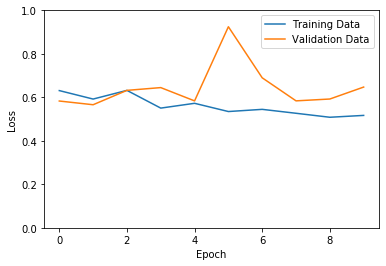

In [41]:
#model.evaluate(x,y) will return a loss and metric values for model on test set data x with labels y

#Visualize training accuracy vs epochs

AccuracyEpochFig = plt.figure(1)
Axes1=AccuracyEpochFig.gca()
Axes1.set_xlabel('Epoch')
Axes1.set_ylabel('Loss')
Axes1.set_ylim([0,1])



plt.figure(1)
plt.plot(train_history.history['loss'], label='Training Data')
plt.plot(train_history.history['val_loss'], label='Validation Data')
Axes1.legend()
plt.show()

In [42]:
test_loss, test_acc = CNNModel.evaluate(TestDataReshaped,TestLabelsReshaped, verbose = 1)
#verbose 0 = silent, 1 = progress bar


115/115 [==============================] - 2s 20ms/sample - loss: 0.6615 - acc: 0.6261


#Notes

##Keras has two models: Sequential and functional API

The sequential model creates an instance of a model of the sequential class then layers are added to it sequentially

Functional models allow multiple input or output models and these models can share layers. It allows creation of models with non-linear shapes (essentially creates a graph of layers instead of sequence)

A sequential model should suffice for starting out

## Convolutional Layer

For creating a convolutional layer, we will use Conv2D since our input is 2D (no RGB channels)
  Found in tensorflow's keras library under layers

Conv2D takes many arguments. A few ones of interest:

filters - number of filters to use in the convolution. 1 filter = 1 "feature" and each filter will increment a third dimension in output space by 1

strides - input as tuple or list of 2 integers to specificy height and width steps per slide. If 1 integer is specified, assumed to apply to both height and width

padding - padding of zeros around input - "valid" means no padding (output dimensions will change), "same" means padding will be done to keep same dimensions

activation - choice of activation function
relu = rectified linear unit - commonly used in CNN
others include elu (exponential linear unit), softmax

input_shape - sequential models require an input shape but then will infer input/output of all the other layers based on the input shape

Output dimension is (n+2p-f)/s + 1 where n is the number of elements in dimension of interest, p is the padding value in that dimension, f is the size of filter in that dimension, s is stride length in that dimension. For s=1, if p=(f-1)/2 then that expression will equal n (no change in size of that dimension)
## MaxPooling2D creates a 2D pooling layer

pool_size - size of the max pooling window

strides = defaults to pool_size (no overlap between windows), otherwise similar to CNN in terms of "steps" per slide

##Dense Layers
Typical neural network (fully connected layers)

##Activation functions
***ReLU

***Softmax

##ResNet
***d

##Compilation and Training

##Model Compile parameters

**optimizer** - choose an optimization algorithm (this is where you would specify learning rate if you wanted)

rmsprop - similar to gradient descent algorithm with momentum

Adam - follow optimization algorithm in the "Adam" paper

**loss** - the cost function to use for training optimization

mean_squared_error

mean_absolute_error

categorical_crossentropy: see https://gombru.github.io/2018/05/23/cross_entropy_loss/

sparse_categorical_crossentropy

**metrics** - function/metric that judges performance of model after training

accuracy - number of correct predictions/total number of predictions

##Input Format

The shape of training labels should be (n,num_classes)
n is number of samples , num_classes is number of classes you have

e.g if you have 300 samples with binary class, the input label vector should be (300,2) with a row looking like 0 1 or 1 0 for each of the 300 samples

if you had 3 classes then you would have (300,3) with a row looking like [1,0,0] , [0,1,0] , or [0,0,1]

##Training Terminology

Batch size = number of training examples to use in a "pass" (can be subset of available data). Weights are updated after going through a batch. Larger batch size requires more memory. Batch size needs to be >= 1 and <= total number of samples

Iterations = number of batches processed (forward and backward passed)

Epoch = forward pass and a backward pass on all training examples. Aka the number of times the algorithm sees the entire data set. Can be any positive integer. 

n epochs completed when batch_size*iterations >= n * number of data samples

note the 3 values are not independent. Can only specify two before the third is defined (eg. 3000 data samples, batches of 300, 1 epoch -> this means 10 iterations will be performed)

##History Object

History object returned by model.fit has .history attribute which has fields of:
"val_loss"
"val_acc"
"loss'
"acc"

1D lists with size equal to # of epochs

##Resources

Coursera Machine Learning by Andrew Ng 

Coursera Deep Learning CNN Course by Andrew Ng

https://keras.io/models/about-keras-models/

https://keras.io/models/model/

https://keras.io/models/sequential/

https://www.tensorflow.org/guide/keras/functional

https://machinelearningmastery.com/keras-functional-api-deep-learning/

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

https://stats.stackexchange.com/questions/360157/epoch-vs-iteration-in-cnn-training

https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

https://www.tensorflow.org/tutorials/images/cnn

https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

https://keras.rstudio.com/reference/fit.html

https://stackoverflow.com/questions/46218407/how-to-interpret-keras-model-fit-output